# Training of Siamese Networks

In [2]:
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from Siamese_model import SiameseTrainer

from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [3]:
def create_pairs(x, digit_indices, num_classes):
    """Creates a balanced dataset of pairs for Siamese networks."""
    pairs = []
    labels = []

    # n: smallest number of instances among all classes in the dataset
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = np.random.randint(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [4]:
def train(self, x_train, y_train, x_val, y_val, batch_size=32, epochs=10):
    # Create digit_indices for training and validation sets
    digit_indices_train = [np.where(y_train == i)[0] for i in range(self.num_classes)]
    digit_indices_val = [np.where(y_val == i)[0] for i in range(self.num_classes)]

    # Create training pairs
    tr_pairs, tr_y = create_pairs(x_train, digit_indices_train, self.num_classes)

    # Create validation pairs
    val_pairs, val_y = create_pairs(x_val, digit_indices_val, self.num_classes)

    # Train the model
    self.history = self.model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))


In [5]:
def load_and_preprocess_image(path, target_size=(96, 96)):
    img = load_img(path, target_size=target_size, color_mode='grayscale')
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Normalize to [0,1]
    return img

# def load_pairs_and_labels(csv_path, image_base_path):
#     df = pd.read_csv(csv_path)
#     pairs = []
#     labels = df['label'].values
    
#     for idx, row in df.iterrows():
#         img1_path = os.path.join(image_base_path, row['image_1'])
#         img2_path = os.path.join(image_base_path, row['image_2'])
        
#         img1 = load_and_preprocess_image(img1_path)
#         img2 = load_and_preprocess_image(img2_path)
        
#         pairs.append([img1, img2])
    
#     pairs = np.array(pairs)
#     # Reshape to fit the Siamese network input
#     pairs = [pairs[:, 0].squeeze(), pairs[:, 1].squeeze()]
    
#     return pairs, labels

def load_pairs_and_labels(csv_path, image_base_path):
    df = pd.read_csv(csv_path)
    pair_images = []
    labels = df['label'].values
    
    for idx, row in df.iterrows():
        img1_path = os.path.join(image_base_path, row['image_1'])
        img2_path = os.path.join(image_base_path, row['image_2'])
        
        img1 = load_and_preprocess_image(img1_path)
        img2 = load_and_preprocess_image(img2_path)
        
        pair_images.append(np.concatenate([img1, img2], axis=0))
    
    # Convert list of pairs to a numpy array
    pairs = np.array(pair_images)
    
    # Since each image pair is concatenated along axis=0, we reshape to ensure
    # the final structure is compatible with what train_model expects
    pairs = pairs.reshape(-1, 2, *pairs.shape[2:])
    
    return pairs, labels


In [6]:
# Create a CNNModel object
def simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [7]:
def new_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        BatchNormalization(),
        Dropout(0.25),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [8]:
input_shape = (96, 96, 1)
num_classes = 3
epochs = 10

train_path = os.getcwd() + "/Split_Siamese/train.csv"
validation_path = os.getcwd() + "/Split_Siamese/validation.csv"
test_path = os.getcwd() + "/Split_Siamese/test.csv"

image_dir = '../OpenSARShip/Categories/'

In [9]:
model = simple_cnn(input_shape, num_classes)

In [10]:
model_new = new_model(input_shape, num_classes)

In [11]:
# Define paths
# image_base_path = '../OpenSARShip/Categories/'
# train_csv_path = os.getcwd() + "/Split_Siamese/train_pairs.csv"
# val_csv_path = os.getcwd() + "/Split_Siamese/val_pairs.csv"
# test_csv_path = os.getcwd() + "/Split_Siamese/test_pairs.csv"

# # Load and preprocess the data
# print("Loading and preprocessing the data train")
# train_pairs, train_labels = load_pairs_and_labels(train_csv_path, image_base_path)
# print("Loading and preprocessing the data val")
# val_pairs, val_labels = load_pairs_and_labels(val_csv_path, image_base_path)
# print("Loading and preprocessing the data test")
# test_pairs, test_labels = load_pairs_and_labels(test_csv_path, image_base_path)

# Define path for quater dataset
image_base_path = '../OpenSARShip/Categories/'

train_csv_path = os.getcwd() + "/Split_quater_siamese/train_pairs.csv"
val_csv_path = os.getcwd() + "/Split_quater_siamese/val_pairs.csv"
test_csv_path = os.getcwd() + "/Split_quater_siamese/test_pairs.csv"

# Load and preprocess the data
print("Loading and preprocessing the data train")
train_pairs, train_labels = load_pairs_and_labels(train_csv_path, image_base_path)
print("Loading and preprocessing the data val")
val_pairs, val_labels = load_pairs_and_labels(val_csv_path, image_base_path)
print("Loading and preprocessing the data test")
test_pairs, test_labels = load_pairs_and_labels(test_csv_path, image_base_path)


Loading and preprocessing the data train
Loading and preprocessing the data val
Loading and preprocessing the data test


In [12]:
# print(type(train_pairs), type(train_labels))
# print(train_pairs.shape, train_labels.shape)

Creating the SiameseTrainer
Compiling the model
Training the model
Epoch 1/30
383/383 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.6832
Epoch 1: val_accuracy improved from -inf to 0.58273, saving model to Siam_batch32_quater_data.pth
INFO:tensorflow:Assets written to: Siam_batch32_quater_data.pth\assets


INFO:tensorflow:Assets written to: Siam_batch32_quater_data.pth\assets


383/383 [==============================] - 110s 285ms/step - loss: 0.5631 - accuracy: 0.6832 - val_loss: 0.6726 - val_accuracy: 0.5827
Epoch 2/30
383/383 [==============================] - ETA: 0s - loss: 0.4757 - accuracy: 0.7909
Epoch 2: val_accuracy improved from 0.58273 to 0.62845, saving model to Siam_batch32_quater_data.pth
INFO:tensorflow:Assets written to: Siam_batch32_quater_data.pth\assets


INFO:tensorflow:Assets written to: Siam_batch32_quater_data.pth\assets


383/383 [==============================] - 108s 281ms/step - loss: 0.4757 - accuracy: 0.7909 - val_loss: 0.6587 - val_accuracy: 0.6284
Epoch 3/30
383/383 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8023
Epoch 3: val_accuracy did not improve from 0.62845
383/383 [==============================] - 111s 289ms/step - loss: 0.4612 - accuracy: 0.8023 - val_loss: 0.7946 - val_accuracy: 0.5363
Epoch 4/30
383/383 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.8056
Epoch 4: val_accuracy did not improve from 0.62845
383/383 [==============================] - 109s 285ms/step - loss: 0.4503 - accuracy: 0.8056 - val_loss: 0.7491 - val_accuracy: 0.5784
Epoch 5/30
383/383 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8908
Epoch 5: val_accuracy did not improve from 0.62845
383/383 [==============================] - 109s 284ms/step - loss: 0.3518 - accuracy: 0.8908 - val_loss: 0.8159 - val_accuracy: 0.5827
Epoch 6/30
383/383 

INFO:tensorflow:Assets written to: Siam_batch32_quater_data.pth\assets


New best model with validation accuracy 0.5529752969741821 saved as Siam_batch32_quater_data.pth
Plotting the training history


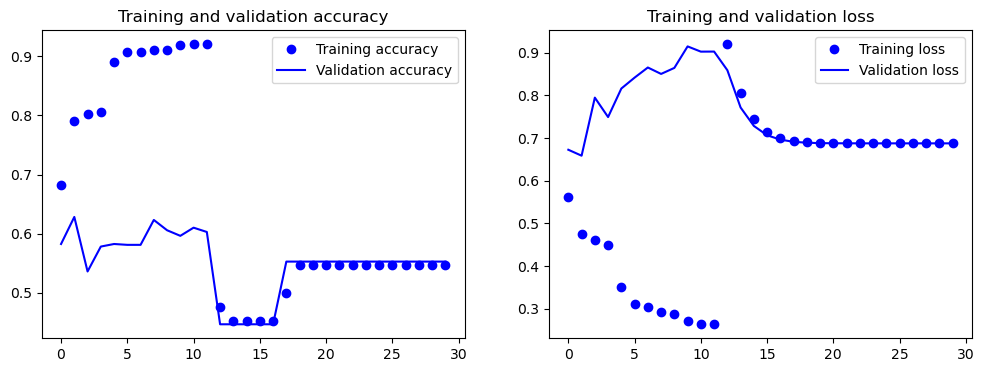

Evaluating the model
42/42 [==============================] - 2s 43ms/step - loss: 0.6811 - accuracy: 0.5860
Test accuracy:  0.5859728455543518


In [13]:
# Assuming `simple_cnn` and `SiameseTrainer` are defined as before
print("Creating the SiameseTrainer")
siamese_network = SiameseTrainer(base_model_func=simple_cnn, input_shape=(96, 96, 1), num_classes=num_classes)
# siamese_network = SiameseTrainer(base_model_func=new_model, input_shape=(96, 96, 1), num_classes=num_classes)

# Set the optimizer
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model
print("Compiling the model")
# siamese_network.compile_model(optimizer='adam', loss='binary_crossentropy')
siamese_network.compile_model(optimizer=optimizer, loss='binary_crossentropy')


# Train the model
print("Training the model")
# siamese_network.train_model(train_pairs, train_labels, val_pairs, val_labels, epochs=10, batch_size=32)
siamese_network.train_model(train_pairs, train_labels, val_pairs, val_labels, epochs=30, batch_size=32, model_save_name='Siam_batch32_quater_data.pth')


# Plot training history
print("Plotting the training history")
siamese_network.plot_training()

# Evaluate the model
print("Evaluating the model")
siamese_network.evaluate_model(test_pairs, test_labels)


Plotting the confusion matrix
42/42 [==============================] - 2s 44ms/step


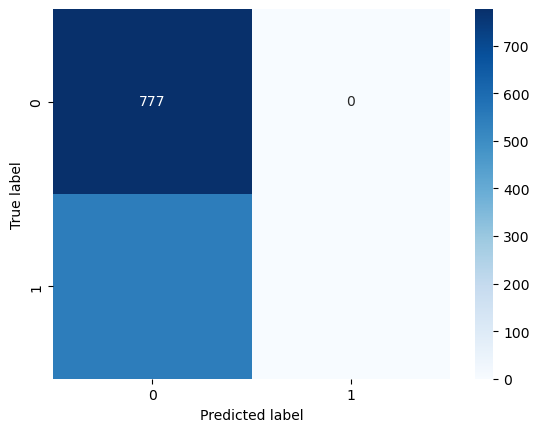

In [15]:
# Plot the confusion matrix
print("Plotting the confusion matrix")
siamese_network.plot_confusion_matrix(test_pairs, test_labels)

In [14]:
# # Assuming you have defined `simple_cnn` as before and have loaded your dataset
# siamese_network = SiameseTrainer(base_model_func=simple_cnn, input_shape=input_shape, num_classes=num_classes)

# # Compile the model with the desired optimizer, loss, and metrics
# siamese_network.compile_model(optimizer='adam', loss='binary_crossentropy')

# # Train the model
# siamese_network.train(x_train, y_train, x_val, y_val, batch_size=32, epochs=10)

# # Plot training history
# siamese_network.plot_training_history()

# # Optionally, evaluate the model on a test set prepared in a similar way
# # siamese_network.evaluate_model(x_test, y_test)
